In [1]:
using Statistics
using PyPlot
using DataFrames
push!(LOAD_PATH, "C:\\Users\\Adam\\Documents\\Git\\FlyDi.jl\\src")
using FlyDi

In [2]:
fil = "../data/quad.h5"
r0 = Vector([-0.0155, -0.008, 0.0]); # coord of pa grid [1, 1] (meters)
fa = h5read_pa(fil, r0);

In [3]:
# calculation
DT = 5e-7
MAX_T = 1e-4
# particle
MASS = 4.002602 * u
n = 37
k = 37
DIPOLE = (3.0 / 2.0) * n * k * q * a0
# electrodes 
voltages = Vector([100.0, -100.0, 100.0, -100.0]);
# starting point
t0 = 0.0;
r0 = Vector([0.001, 0.00, 0.193]);
v0 = Vector([-5, 30, -1820.0]);

In [4]:
# Euler integration method
@time eu = traj(fa, voltages, t0, r0, v0, DIPOLE, MASS, DT, euler, max_t=MAX_T, df=true);

  3.102374 seconds (7.79 M allocations: 390.328 MiB, 5.26% gc time)


In [5]:
# Leapfrog integration method
@time lf = traj(fa, voltages, t0, r0, v0, DIPOLE, MASS, DT, leapfrog, max_t=MAX_T, df=true);

  0.636305 seconds (1.54 M allocations: 80.128 MiB, 4.30% gc time)


In [6]:
# Runge Kutta integration method
@time rk = traj(fa, voltages, t0, r0, v0, DIPOLE, MASS, DT, rk4, max_t=MAX_T, df=true);

  0.713929 seconds (2.19 M allocations: 112.985 MiB, 7.10% gc time)


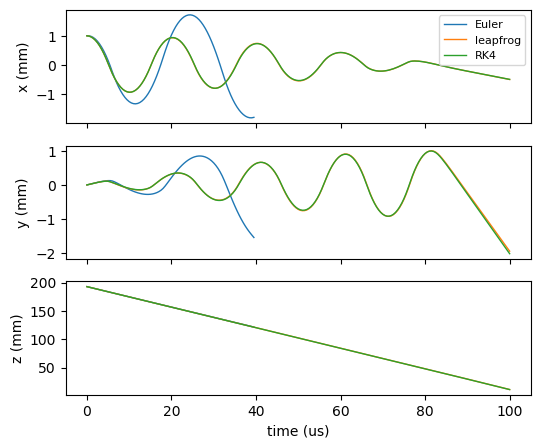

In [7]:
# 3D trajectory
fig, ax = subplots(3, 1, figsize=(6, 5), sharex=true)

colors = ["C0", "C1", "C2"]
labels = ["Euler", "leapfrog", "RK4"]
for (tr, color, lbl) in zip([eu, lf, rk], colors, labels)
    ax[1, 1].plot(tr.t*1e6, tr.x*1e3, color=color, lw=1, label=lbl)
    ax[2, 1].plot(tr.t*1e6, tr.y*1e3, color=color, lw=1)
    ax[3, 1].plot(tr.t*1e6, tr.z*1e3, color=color, lw=1)
end

ax[1, 1].legend(fontsize=8)
ax[1, 1].set_ylabel("x (mm)")
ax[2, 1].set_ylabel("y (mm)")
ax[3, 1].set_ylabel("z (mm)")
ax[3, 1].set_xlabel("time (us)")
;

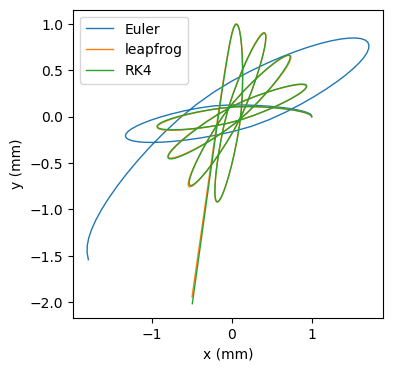

In [8]:
# 2D trajectory

fig, ax = subplots(figsize=(4, 4))
for (tr, color, lbl) in zip([eu, lf, rk], colors, labels)
    plot(tr.x*1e3, tr.y*1e3, color=color, label=lbl, lw=1)
end
legend()
xlabel("x (mm)")
ylabel("y (mm)")
;

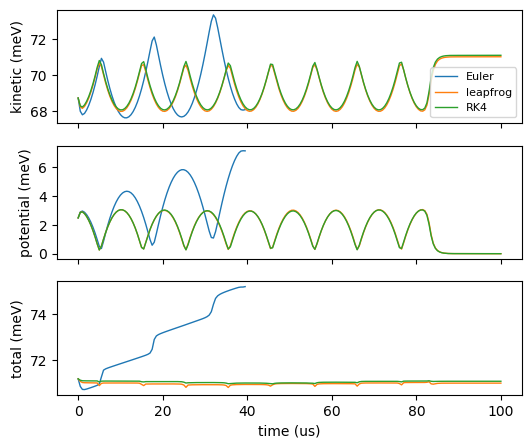

In [9]:
# Energy (total energy should not change!)

fig, ax = subplots(3, 1, figsize=(6, 5), sharex=true)

for (tr, color, lbl) in zip([eu, lf, rk], colors, labels)
    ax[1, 1].plot(tr.t*1e6, tr.KE*1e3 / q, color=color, lw=1, label=lbl)
    ax[2, 1].plot(tr.t*1e6, tr.PE*1e3 / q, color=color, lw=1)
    ax[3, 1].plot(tr.t*1e6, (tr.KE + tr.PE)*1e3 / q, color=color, lw=1)
end

ax[1, 1].legend(fontsize=8)
ax[1, 1].set_ylabel("kinetic (meV)")
ax[2, 1].set_ylabel("potential (meV)")
ax[3, 1].set_ylabel("total (meV)")
ax[3, 1].set_xlabel("time (us)")
;

In [10]:
# compare timesteps

dt_vals = 1e-8 * Array(1: 10).^2.0

# fly dipoles
num = size(dt_vals)[1]
result = Array{DataFrame, 2}(undef, num, 3)
methods = [euler, leapfrog, rk4]
for (j, method) in enumerate(methods)
    for (i, dt) in enumerate(dt_vals)
        @time result[i, j] = traj(fa, voltages, t0, r0, v0, DIPOLE, MASS, dt, method, max_t=MAX_T, df=true);
    end
end

  2.377531 seconds (8.51 M allocations: 3.125 GiB, 20.38% gc time)
  0.312135 seconds (2.13 M allocations: 299.221 MiB, 14.87% gc time)
  0.115072 seconds (946.36 k allocations: 91.898 MiB, 15.06% gc time)
  0.058932 seconds (532.77 k allocations: 43.625 MiB, 11.43% gc time)
  0.035536 seconds (340.44 k allocations: 25.473 MiB, 9.13% gc time)
  0.014448 seconds (155.88 k allocations: 10.607 MiB)
  0.010283 seconds (70.03 k allocations: 4.543 MiB, 31.40% gc time)
  0.005271 seconds (53.03 k allocations: 3.407 MiB)
  0.003083 seconds (31.78 k allocations: 2.016 MiB)
  0.002342 seconds (24.13 k allocations: 1.524 MiB)
  2.061753 seconds (8.56 M allocations: 3.168 GiB, 19.33% gc time)
  0.290825 seconds (2.14 M allocations: 310.328 MiB, 14.49% gc time)
  0.114067 seconds (952.64 k allocations: 96.863 MiB, 14.06% gc time)
  0.060368 seconds (536.63 k allocations: 46.440 MiB, 12.54% gc time)
  0.037400 seconds (343.16 k allocations: 27.288 MiB, 8.68% gc time)
  0.026710 seconds (238.74 k all

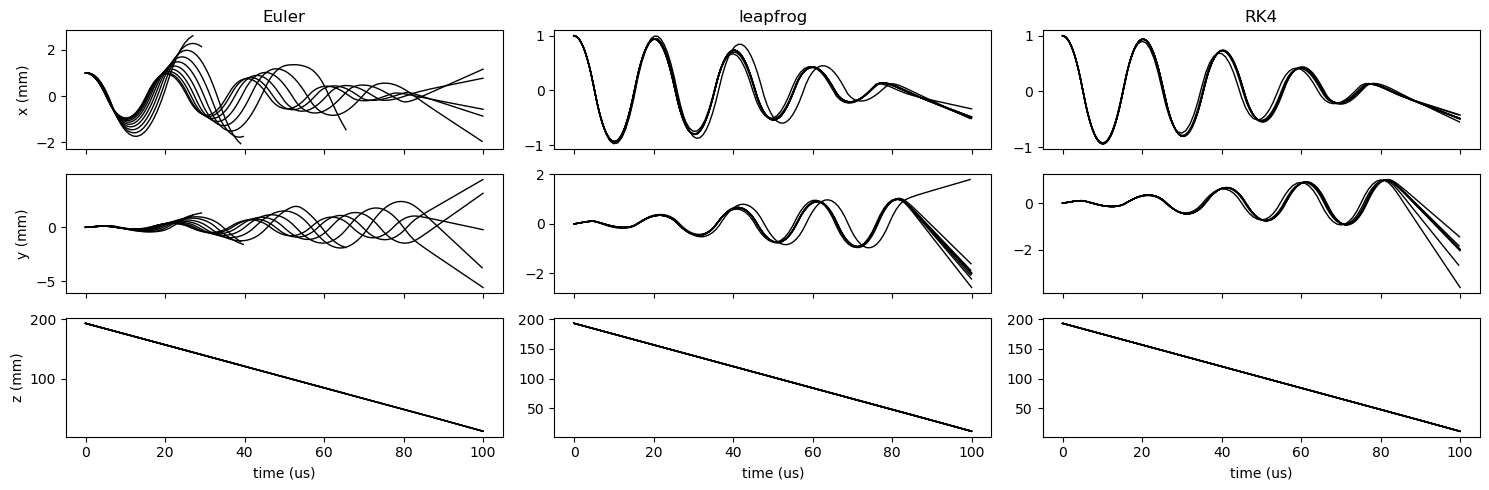

In [11]:
# timesteps versus trajectory

fig, ax = subplots(3, 3, figsize=(15, 5), sharex=true)
color = "black" 
lbl = "Euler"
for j in 1:size(result)[2]
    for tr in result[:, j]
        ax[1, j].plot(tr.t*1e6, tr.x*1e3, color=color, lw=1)
        ax[2, j].plot(tr.t*1e6, tr.y*1e3, color=color, lw=1)
        ax[3, j].plot(tr.t*1e6, tr.z*1e3, color=color, lw=1)
    end
end
ax[1, 1].set_title("Euler")
ax[1, 2].set_title("leapfrog")
ax[1, 3].set_title("RK4")
ax[1, 1].set_ylabel("x (mm)")
ax[2, 1].set_ylabel("y (mm)")
ax[3, 1].set_ylabel("z (mm)")
ax[3, 1].set_xlabel("time (us)")
ax[3, 2].set_xlabel("time (us)")
ax[3, 3].set_xlabel("time (us)")
tight_layout()
;

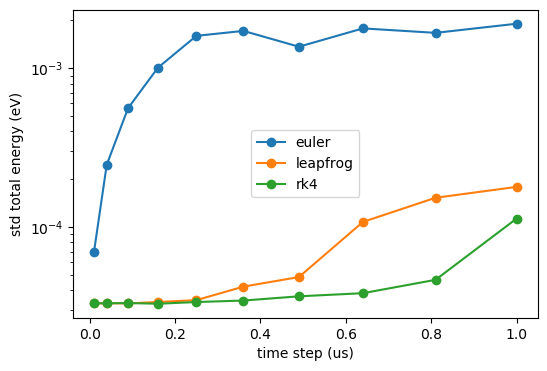

In [12]:
# timesteps versus standard deviation in the total energy
# [std(total_energy) should tend to zero]

en_std = Array{Float64}(undef, size(result))
for j in 1:size(result)[2]
    for i in 1:size(result)[1]
        tr = result[i, j]
        en_std[i, j] = std((tr[:PE] + tr[:KE]) / q)
    end
end

# plot
fig, ax = subplots(1, 1, figsize=(6, 4))

for (j, lbl) in enumerate(methods)
    plot(dt_vals * 1e6, en_std[:, j], marker="o", label=String(nameof(lbl)))
end

legend()
ylabel("std total energy (eV)")
yscale("log")
xlabel("time step (us)")
;